<a href="https://colab.research.google.com/github/ce3tnia/SubmissionDicoding/blob/main/DicodingSubmission_Cecilia_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download Dataset from Kaggle**

In [ ]:
#install kaggle package
!pip install -q kaggle

In [ ]:
#kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ce3tnia","key":"03dd7be24c9fa220b11462fb1bd9c224"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d hgultekin/bbcnewsarchive

bbcnewsarchive.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzip dataset
!mkdir bbcnewsarchive
!unzip bbcnewsarchive.zip -d bbcnewsarchive
!ls bbcnewsarchivey

mkdir: cannot create directory ‘bbcnewsarchive’: File exists
Archive:  bbcnewsarchive.zip
replace bbcnewsarchive/bbc-news-data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bbcnewsarchive/bbc-news-data.csv  
bbc-news-data.csv


# **Import Library and Download Package**

In [ ]:
import pandas as pd

import nltk, os, re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')

from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Load Dataset**

In [ ]:
#load 10 data pertama
df = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t')
df.head(10)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
5,business,006.txt,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...
6,business,007.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
7,business,008.txt,India calls for fair trade rules,"India, which attends the G7 meeting of seven ..."
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...
9,business,010.txt,Court rejects $280bn tobacco case,A US government claim accusing the country's ...


In [ ]:
#data kolom
df.columns

Index(['category', 'filename', 'title', 'content'], dtype='object')

In [ ]:
#total data
df.shape

(2225, 4)

In [ ]:
#cek data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [ ]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
#hapus kolom yang tidak digunakan (filename)
df_new = df.drop(columns=['filename'])
df_new.head(5)

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


# **Cleaning Data**

In [ ]:
#lower-case characters
df_new.title = df_new.title.apply(lambda x: x.lower())
df_new.content = df_new.content.apply(lambda x: x.lower())

In [ ]:
#removing number
def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df_new['title'].apply(rem_numbers)
    df_new['content'].apply(rem_numbers)

In [ ]:
#removing stopword
st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df_new.title = df_new.title.apply(lambda x: stopword(x))
    df_new.content = df_new.content.apply(lambda x: lem(x))

In [ ]:
df_new.head(10)

,category,title,content
0,business,ad sales boost time warner profit,quarterly profits at us media giant timewarne...
1,business,dollar gains on greenspan speech,the dollar has hit its highest level against ...
2,business,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...
3,business,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...
4,business,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...
5,business,japan narrowly escapes recession,japan's economy teetered on the brink of a te...
6,business,jobs growth still slow in the us,the us created fewer jobs than expected in ja...
7,business,india calls for fair trade rules,"india, which attends the g7 meeting of seven ..."
8,business,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...
9,business,court rejects $280bn tobacco case,a us government claim accusing the country's ...


# **Labeling**

In [ ]:
#one-hot-encoding
category = pd.get_dummies(df_new.category)
df_new_ctg = pd.concat([df_new, category], axis=1)
df_new_ctg = df_new_ctg.drop(columns='category')
df_new_ctg.head(10)

,title,content,business,entertainment,politics,sport,tech
0,ad sales boost time warner profit,quarterly profits at us media giant timewarne...,1,0,0,0,0
1,dollar gains on greenspan speech,the dollar has hit its highest level against ...,1,0,0,0,0
2,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...,1,0,0,0,0
3,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...,1,0,0,0,0
4,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...,1,0,0,0,0
5,japan narrowly escapes recession,japan's economy teetered on the brink of a te...,1,0,0,0,0
6,jobs growth still slow in the us,the us created fewer jobs than expected in ja...,1,0,0,0,0
7,india calls for fair trade rules,"india, which attends the g7 meeting of seven ...",1,0,0,0,0
8,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...,1,0,0,0,0
9,court rejects $280bn tobacco case,a us government claim accusing the country's ...,1,0,0,0,0


In [ ]:
#ubah ke numpy array
news = df_new_ctg['title'].values + '' + df_new_ctg['content'].values
label = df_new_ctg[['business', 'entertainment', 'politics', 'sport', 'tech']].values

news

array(['ad sales boost time warner profit quarterly profits at us media giant timewarner jumped 76% to $1.13bn (£600m) for the three months to december, from $639m year-earlier.  the firm, which is now one of the biggest investors in google, benefited from sales of high-speed internet connections and higher advert sales. timewarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. its profits were buoyed by one-off gains which offset a profit dip at warner bros, and less users for aol.  time warner said on friday that it now owns 8% of search-engine google. but its own internet business, aol, had has mixed fortunes. it lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. however, the company said aol\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. it hopes to increase subscribers by offering the online service free to timewarner internet customers and will try to sig

In [ ]:
label

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

# **Model**

In [ ]:
#split data ke train dan validasi
news_train, news_test, label_train, label_test = train_test_split(news, label, test_size=0.2, shuffle=True)

In [ ]:
#tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(news_train) 
tokenizer.fit_on_texts(news_test)
 
sekuens_train = tokenizer.texts_to_sequences(news_train)
sekuens_test = tokenizer.texts_to_sequences(news_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [ ]:
#buat model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 435,973
Trainable params: 435,973
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nakurasi telah mencapai > 90%")
callbacks = myCallback()

In [ ]:
#fitting model
history = model.fit(padded_train, label_train, epochs=50, 
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks], validation_steps=30)

Epoch 1/50
56/56 - 14s - loss: 1.6042 - accuracy: 0.2360 - val_loss: 1.5374 - val_accuracy: 0.2584
Epoch 2/50
56/56 - 11s - loss: 1.3538 - accuracy: 0.4635 - val_loss: 0.9906 - val_accuracy: 0.5775
Epoch 3/50
56/56 - 12s - loss: 0.6497 - accuracy: 0.7522 - val_loss: 0.4954 - val_accuracy: 0.8292
Epoch 4/50
56/56 - 12s - loss: 0.3532 - accuracy: 0.8916 - val_loss: 0.8472 - val_accuracy: 0.7101
Epoch 5/50
56/56 - 11s - loss: 0.4657 - accuracy: 0.8528 - val_loss: 0.7851 - val_accuracy: 0.7101
Epoch 6/50
56/56 - 11s - loss: 0.2146 - accuracy: 0.9360 - val_loss: 0.7014 - val_accuracy: 0.7753
Epoch 7/50
56/56 - 11s - loss: 0.0690 - accuracy: 0.9826 - val_loss: 0.4708 - val_accuracy: 0.8787
Epoch 8/50
56/56 - 11s - loss: 0.0790 - accuracy: 0.9764 - val_loss: 0.6836 - val_accuracy: 0.8135
Epoch 9/50
56/56 - 12s - loss: 0.1671 - accuracy: 0.9461 - val_loss: 0.6613 - val_accuracy: 0.7820
Epoch 10/50
56/56 - 12s - loss: 0.0238 - accuracy: 0.9972 - val_loss: 0.6414 - val_accuracy: 0.8157
Epoch 11/

# **Plotting**

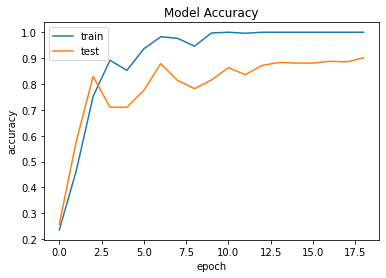

In [ ]:
#plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

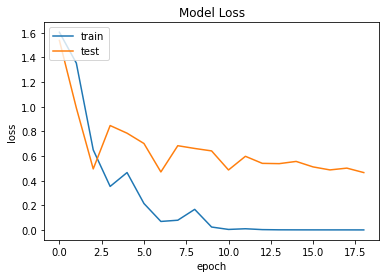

In [ ]:
#plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()